## Graph Neural Networks (GNNs)
### Định nghĩa
GNNs là công cụ thiết kế để nắm bắt sự phụ thuộc của đồ thị thông qua việc truyền thông điệp giữa các nút của đồ thị, là một lớp mô hình học sâu được thiết kế để hoạt động trên dữ liệu có cấu trúc đồ thị (Graph). Chúng đã chứng minh hiệu quả cao cho các nhiệm vụ liên quan đến dữ liệu có cấu trúc đồ thị, như mạng xã hội, hệ thống gợi ý, và hóa học.

Trong dữ liệu đồ thị, các đối tượng (node) và mối quan hệ giữa chúng (edge) được biểu diễn dưới dạng đồ thị G = (V, E):

- V: Tập hợp các đỉnh (nodes).

- E: Tập hợp các cạnh (edges) kết nối giữa các đỉnh.

GNN giúp học biểu diễn (representation learning) cho các node, cạnh hoặc toàn bộ đồ thị dựa trên cả đặc trưng của node và cấu trúc đồ thị.

### Các thành phần chính của GNNs
GNN bao gồm 3 thành phần cơ bản:

1. Node Features:
Mỗi node $h_v$ của node $v$.

2. Message Passing (Lan truyền tin):  
   Mỗi node thu thập thông tin từ các node lân cận thông qua các cạnh kết nối.  
   Công thức tổng quát:

   $$
   h_v^{(k)} = \text{AGGREGATE} \left( h_u^{(k-1)}, \forall u \in \mathcal{N}(v) \right)
   $$

   - $h_v^{(k)}$: Đặc trưng của node $v$ tại lớp $k$.  
   - $\mathcal{N}(v)$: Tập lân cận của node $v$.
   - AGGREGATE: Hàm tổng hợp thông tin (ví dụ: trung bình, tổng hoặc hàm phi tuyến).

3. Update:  
   Node cập nhật đặc trưng bằng hàm phi tuyến:

   $$
   h_v^{(k)} = \text{UPDATE} \left( h_v^{(k-1)}, \text{AGGREGATE} \right)
   $$

   Hàm UPDATE thường là một hàm phi tuyến (ví dụ: sử dụng MLP hoặc ReLU).


### Ứng dụng của GNN
GNN có nhiều ứng dụng thực tế trong các lĩnh vực khác nhau:

1. Mạng xã hội:
- Phân loại người dùng (phân loại node).
- Dự đoán kết nối mới (dự đoán cạnh).

2. Hệ thống khuyến nghị:
- Khuyến nghị sản phẩm dựa trên mối quan hệ người dùng và sản phẩm.

3. Hóa học và sinh học:
- Dự đoán tính chất của phân tử (phân loại đồ thị).
- Phân tích mạng protein tương tác (PPI).

### Đánh giá tổng quan
Trong thực tế, GNN xử lý sự mất cân bằng giữa các liên kết hiện có và không hiện có bằng cách sử dụng lấy mẫu tiêu cực, nơi các cạnh không tồn tại (ví dụ tiêu cực) được lấy mẫu để cân bằng với những cái hiện có (ví dụ tích cực). Phương pháp này giúp mô hình học được biểu diễn đồ thị một cách tổng quát hơn.

Để đào tạo hiệu quả trên các đồ thị lớn, các phương pháp như lấy mẫu hàng xóm được sử dụng, nơi mô hình lặp đi lặp lại học từ các minibatch của các cạnh thay vì toàn bộ đồ thị ngay lập tức. Phương pháp này giảm chi phí tính toán và làm cho mô hình có thể mở rộng được với các bộ dữ liệu lớn.

In [ ]:
%%capture
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"

In [22]:
from torch_geometric.datasets import Planetoid, TUDataset,PPI
from torch_geometric.transforms import NormalizeFeatures

dataset = PPI(root='data/Planetoid' ,transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)


Extracting data\Planetoid\ppi.zip
Processing...


Dataset: PPI(20):
Number of graphs: 20
Number of features: 50
Number of classes: 121
Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])


Done!


In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import torch_geometric.utils as pyg_utils

In [24]:
class LinkPrediction:
    def __init__(self, data):
        self.G = pyg_utils.to_networkx(data, to_undirected=True)
        print("Đọc file thành công!")

    def analyze_network(self):
        """Phân tích cơ bản về mạng."""
        print("\n=== Phân tích mạng ===")
        print(f"Số node: {self.G.number_of_nodes()}")
        print(f"Số cạnh: {self.G.number_of_edges()}")
        print(f"Clustering trung bình: {nx.average_clustering(self.G.to_undirected()):.3f}")

        plt.figure(figsize=(15, 5))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title("Cấu trúc mạng")
        plt.show()

    def prepare_data(self):
        """Chuẩn bị dữ liệu train và test."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        n_test = int(len(edges) * 0.2)
        self.test_edges = edges[:n_test]
        self.train_edges = edges[n_test:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:n_test]
        print(f"Train edges: {len(self.train_edges)}")
        print(f"Test positive edges: {len(self.test_edges)}")
        print(f"Test negative edges: {len(self.test_non_edges)}")

    def extract_features(self, G, u, v):
        """Trích xuất features cho các node pairs."""
        undirected_G = G.to_undirected()  # Chuyển thành đồ thị vô hướng tạm thời
        cn = len(list(nx.common_neighbors(undirected_G, u, v)))
        jc = list(nx.jaccard_coefficient(undirected_G, [(u, v)]))[0][2]
        aa = list(nx.adamic_adar_index(undirected_G, [(u, v)]))[0][2]
        pa = list(nx.preferential_attachment(undirected_G, [(u, v)]))[0][2]
        return [cn, jc, aa, pa]

    def prepare_ml_data(self, G, positive_edges, negative_edges):
        """Tạo dữ liệu cho machine learning."""
        undirected_G = G.to_undirected()  # Chuyển toàn bộ đồ thị thành vô hướng
        X = [self.extract_features(undirected_G, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def evaluate_baselines(self):
        """Đánh giá các phương pháp truyền thống."""
        # Chuyển đồ thị có hướng thành vô hướng
        undirected_train_G = self.train_G.to_undirected()

        methods = {
            'Common Neighbors': lambda u, v: len(list(nx.common_neighbors(undirected_train_G, u, v))),'Jaccard Coefficient': lambda u, v: list(nx.jaccard_coefficient(undirected_train_G, [(u, v)]))[0][2],
            'Adamic-Adar': lambda u, v: list(nx.adamic_adar_index(undirected_train_G, [(u, v)]))[0][2],
            'Preferential Attachment': lambda u, v: list(nx.preferential_attachment(undirected_train_G, [(u, v)]))[0][2],
        }

        results = []

        for name, score_func in methods.items():
            # Tính điểm cho positive và negative edges
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            # Tạo y_true và y_scores
            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores

            # Tính AUC
            auc = roc_auc_score(y_true, y_scores)

            # Lưu kết quả
            results.append({
                "Method": name,
                "AUC": auc
            })

        # Chuyển kết quả thành DataFrame
        self.results_df = pd.DataFrame(results)
        print("\nBảng kết quả so sánh các phương pháp:")
        print(self.results_df)

    def evaluate_ml(self):
        """Huấn luyện mô hình Machine Learning và đánh giá."""
        X, y = self.prepare_ml_data(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_pred_proba)
        print(f"\nAUC của Random Forest: {auc:.3f}")

    def run_experiment(self):
        """Chạy thử nghiệm."""
        self.analyze_network()
        self.prepare_data()
        self.evaluate_baselines()
        self.evaluate_ml()


Đọc file thành công!

=== Phân tích mạng ===
Số node: 1767
Số cạnh: 16159
Clustering trung bình: 0.159


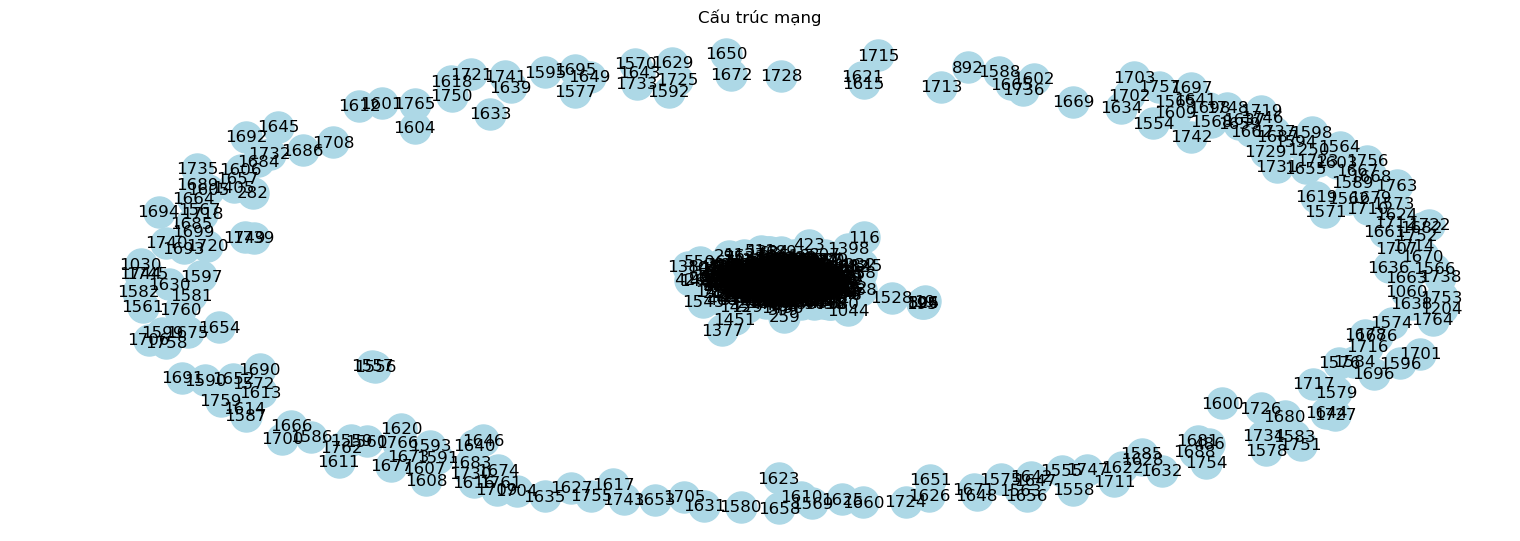

Train edges: 12928
Test positive edges: 3231
Test negative edges: 3231

Bảng kết quả so sánh các phương pháp:
                    Method       AUC
0         Common Neighbors  0.852627
1      Jaccard Coefficient  0.830863
2              Adamic-Adar  0.855986
3  Preferential Attachment  0.885826

AUC của Random Forest: 0.879


In [25]:
base = LinkPrediction(data)
base.run_experiment()

In [38]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)  # First GCN layer
        self.conv2 = GCNConv(16, num_classes)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # Second Layer
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

In [52]:
dataset = PPI(root='data/Planetoid' ,transform=NormalizeFeatures())
data = dataset[0]
num_nodes = data.num_nodes
num_train = int(num_nodes * 0.8)  # 80% for training
num_val = int(num_nodes * 0.1)  # 10% for validation
num_test = num_nodes - num_train - num_val  # 10% for testing
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:num_train] = True
val_mask[num_train:num_train + num_val] = True
test_mask[num_train + num_val:] = True
indices = torch.randperm(num_nodes)
train_mask = train_mask[indices]
val_mask = val_mask[indices]
test_mask = test_mask[indices]

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_features=50, num_classes=121).to(device)
data = data.to(device)
data.y = data.y.argmax(dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
loss_function = torch.nn.CrossEntropyLoss()
for epoch in range(5000):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_function(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 4.785572052001953
Epoch 11, Loss: 4.122675895690918
Epoch 21, Loss: 2.8112099170684814
Epoch 31, Loss: 1.5932655334472656
Epoch 41, Loss: 1.3080648183822632
Epoch 51, Loss: 1.2544153928756714
Epoch 61, Loss: 1.2300820350646973
Epoch 71, Loss: 1.2120842933654785
Epoch 81, Loss: 1.203656792640686
Epoch 91, Loss: 1.2027496099472046
Epoch 101, Loss: 1.2069478034973145
Epoch 111, Loss: 1.2000805139541626
Epoch 121, Loss: 1.199440598487854
Epoch 131, Loss: 1.1920207738876343
Epoch 141, Loss: 1.1825209856033325
Epoch 151, Loss: 1.1775201559066772
Epoch 161, Loss: 1.1793292760849
Epoch 171, Loss: 1.1815232038497925
Epoch 181, Loss: 1.1915751695632935
Epoch 191, Loss: 1.1878328323364258
Epoch 201, Loss: 1.180312156677246
Epoch 211, Loss: 1.1757800579071045
Epoch 221, Loss: 1.1762641668319702
Epoch 231, Loss: 1.1760802268981934
Epoch 241, Loss: 1.1627286672592163
Epoch 251, Loss: 1.1652209758758545
Epoch 261, Loss: 1.166893482208252
Epoch 271, Loss: 1.1731500625610352
Epoch 281, L

In [54]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        correct = (pred == data.y).sum()
        accuracy = int(correct) / int(data.y.size(0))
    return accuracy

# Assume you have a test mask or similar way to identify test data points
test_accuracy = evaluate(model, data)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7578


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.117153
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.655033
[t-SNE] KL divergence after 300 iterations: 0.435675


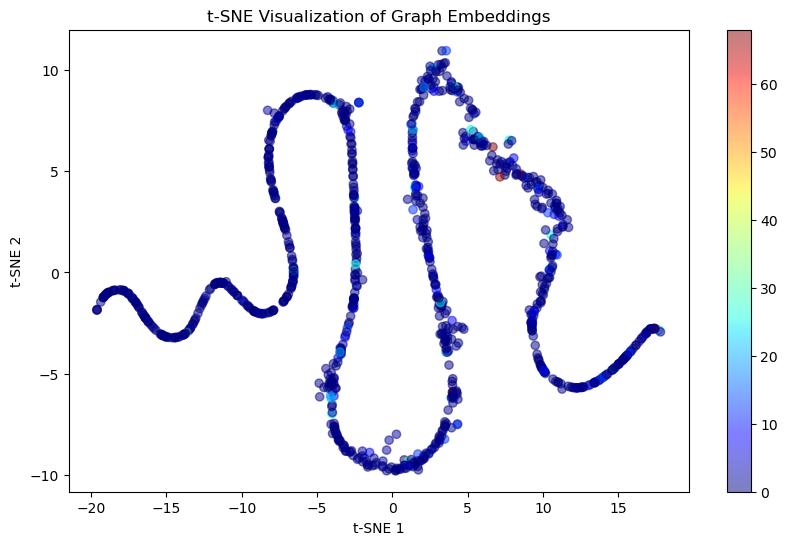

In [55]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(model, data, num_points=1000):
    model.eval()
    with torch.no_grad():
        out = model(data)
        # Get the embeddings from the last layer before softmax
        embeddings = out.detach().cpu().numpy()

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(embeddings[:num_points])

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=data.y[:num_points].detach().cpu().numpy(), cmap='jet', alpha=0.5)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Graph Embeddings")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()

# Call the visualization function
visualize_embeddings(model, data)
